In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

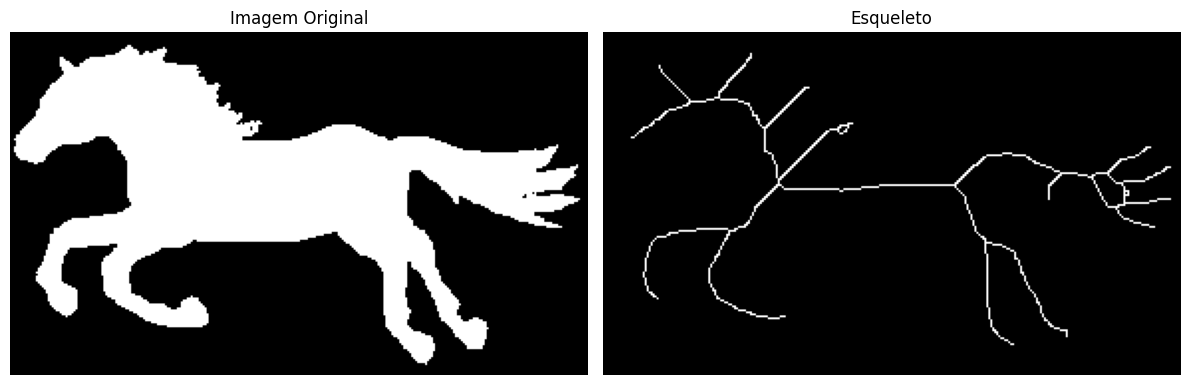

In [21]:
#Esqueletonização.
def skeletonize(img):

    img = img.copy()
    
    while True:
        alterado = False

        pixels_para_remover = []
        for i in range(1, img.shape[0] - 1):
            for j in range(1, img.shape[1] - 1):
                if img[i, j] == 255:
                    vizinhos = [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
                                img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]
                    B = sum(v == 255 for v in vizinhos)
                    A = sum((vizinhos[k] == 0 and vizinhos[(k+1) % 8] == 255) for k in range(8))
                    
                    if (2 <= B <= 6) and (A == 1) and \
                       (vizinhos[0] == 0 or vizinhos[2] == 0 or vizinhos[4] == 0) and \
                       (vizinhos[2] == 0 or vizinhos[4] == 0 or vizinhos[6] == 0):
                        pixels_para_remover.append((i, j))

        for i, j in pixels_para_remover:
            img[i, j] = 0
            alterado = True

        pixels_para_remover = []
        for i in range(1, img.shape[0] - 1):
            for j in range(1, img.shape[1] - 1):
                if img[i, j] == 255:
                    vizinhos = [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
                                img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]
                    B = sum(v == 255 for v in vizinhos)
                    A = sum((vizinhos[k] == 0 and vizinhos[(k+1) % 8] == 255) for k in range(8))

                    if (2 <= B <= 6) and (A == 1) and \
                       (vizinhos[0] == 0 or vizinhos[2] == 0 or vizinhos[6] == 0) and \
                       (vizinhos[0] == 0 or vizinhos[4] == 0 or vizinhos[6] == 0):
                        pixels_para_remover.append((i, j))

        for i, j in pixels_para_remover:
            img[i, j] = 0
            alterado = True

        if not alterado:
            break

    return img

imagem = cv2.imread("horse.png", cv2.IMREAD_GRAYSCALE)
imagem_binaria = (imagem == 0).astype(np.uint8) * 255
esqueleto = skeletonize(imagem_binaria)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(imagem_binaria, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Esqueleto")
plt.imshow(esqueleto, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


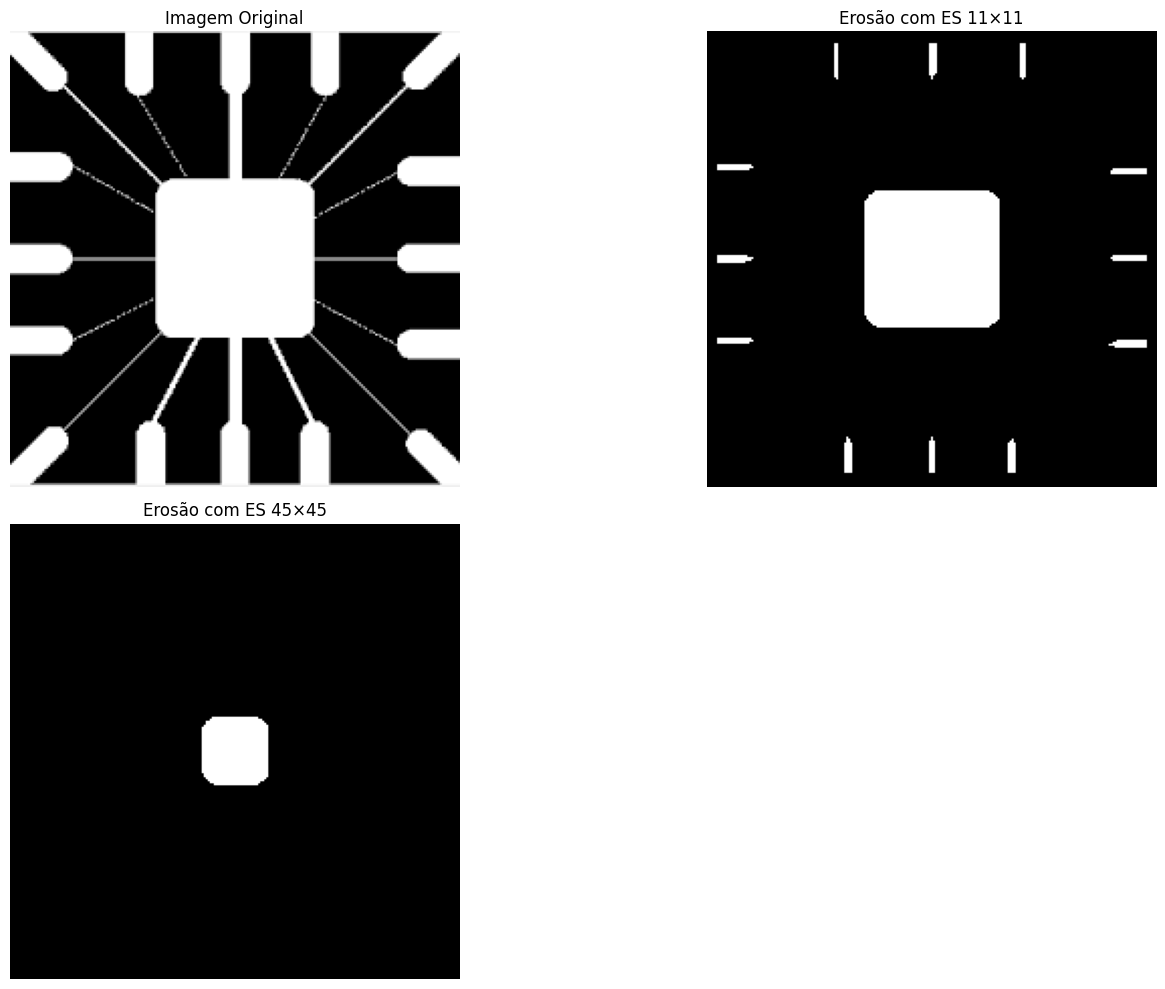

In [22]:
#erosao
def erosion(image, kernel_size):
    
    height, width = image.shape
    margin = kernel_size // 2
    
    eroded_image = np.zeros_like(image)
    
    for i in range(margin, height - margin):
        for j in range(margin, width - margin):
            region = image[i-margin:i+margin+1, j-margin:j+margin+1]
            eroded_image[i, j] = 255 if np.all(region == 255) else 0
    
    return eroded_image

original_image = cv2.imread('erosao.png', cv2.IMREAD_GRAYSCALE)

eroded_image_11 = erosion(original_image, 11)
eroded_image_45 = erosion(original_image, 45)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(eroded_image_11, cmap='gray')
plt.title('Erosão com ES 11×11')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(eroded_image_45, cmap='gray')
plt.title('Erosão com ES 45×45')
plt.axis('off')

plt.tight_layout()
plt.show()

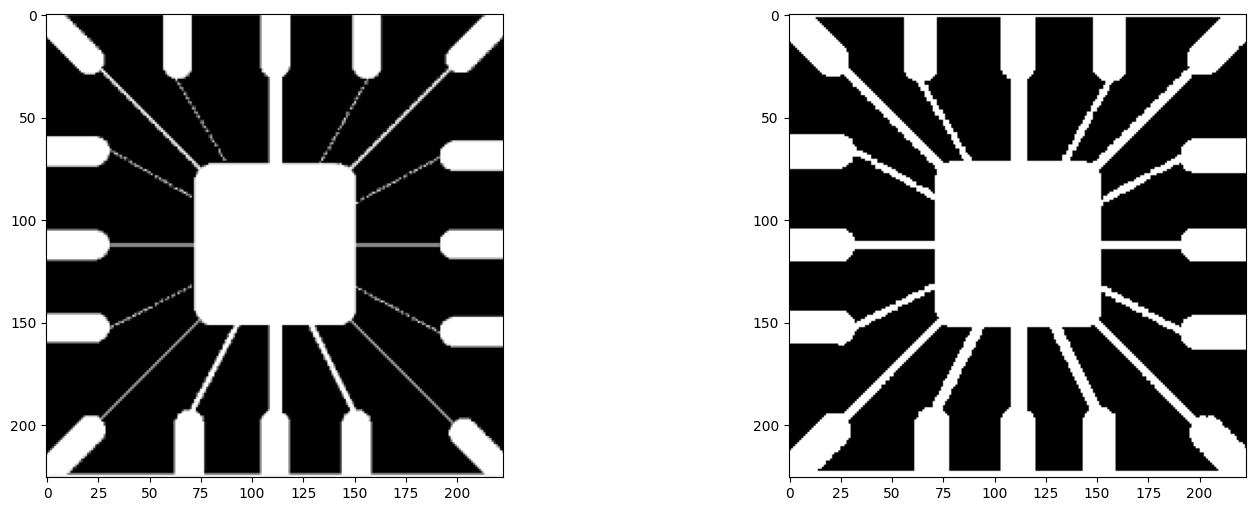

In [23]:
# dilation
def dilation(image, structuring_element):

    if set(np.unique(image)) - {0, 255}:
        raise ValueError("Image must be binary (0 and 255)")

    img = (image == 255).astype(np.uint8)
    if isinstance(structuring_element, int):
        size = structuring_element
        kernel = np.ones((size, size), dtype=np.uint8)
    else:
        kernel = structuring_element.astype(np.uint8)

    h, w = img.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    temp = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            region = padded[i:i + k_h, j:j + k_w]
            temp[i, j] = np.max(region * kernel)

    return temp * 255


img = cv2.imread('erosao.png', 0)
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

kernel = np.ones((3,3), dtype=np.uint8)

result = dilation(binary_img, kernel)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.tight_layout()
plt.show()

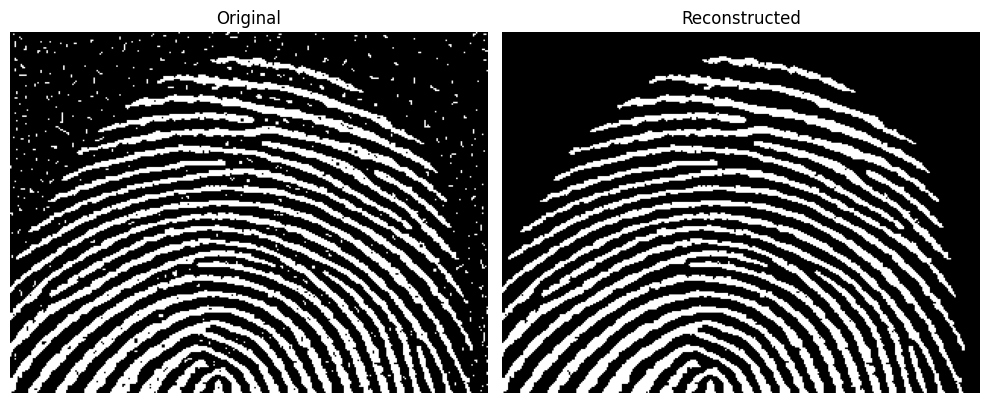

In [24]:
# reconstruction dilation/erosion
def reconstruction(image, kernel_size=3, max_iter=100):

    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # 1. Erosion reconstruction
    marker = erosion(image, kernel_size)
    rec_ero = marker.copy()
    for _ in range(max_iter):
        dilated = dilation(rec_ero, kernel)
        new = np.minimum(dilated, image)
        if np.array_equal(new, rec_ero):
            break
        rec_ero = new
    
    # 2. Dilation reconstruction
    marker = dilation(rec_ero, kernel)
    rec_dil = marker.copy()
    for _ in range(max_iter):
        eroded = erosion(rec_dil, kernel_size)
        new = np.maximum(eroded, rec_ero)
        if np.array_equal(new, rec_dil):
            break
        rec_dil = new
    
    return rec_dil


if __name__ == "__main__":

    img = cv2.imread('digital.jpg', 0)
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    result = reconstruction(binary_img, kernel_size=3)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_img, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

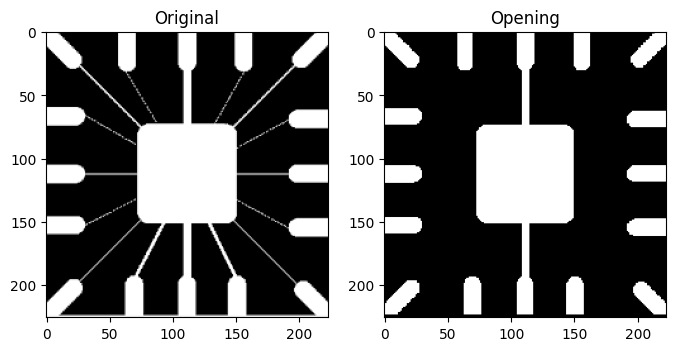

In [25]:
def opening(image, structuring_element, iterations=1):
    img = (image == 255).astype(np.uint8)
    kernel = structuring_element.astype(np.uint8)
    
    height, width = img.shape
    k_height, k_width = kernel.shape
    pad_height, pad_width = k_height // 2, k_width // 2

    for _ in range(iterations):
        # Erosion step
        padded = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
        temp_erode = np.zeros_like(img)
        
        for i in range(height):
            for j in range(width):
                region = padded[i:i+k_height, j:j+k_width]
                temp_erode[i,j] = 1 if np.all(region * kernel == kernel) else 0
        
        # Dilation step
        padded = np.pad(temp_erode, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
        temp_dilate = np.zeros_like(temp_erode)
        
        for i in range(height):
            for j in range(width):
                region = padded[i:i+k_height, j:j+k_width]
                temp_dilate[i,j] = 1 if np.any(region * kernel) else 0
        
        img = temp_dilate.copy()
    
    return img * 255


kernel = np.ones((5,5), dtype=np.uint8)
img = cv2.imread('erosao.png', 0)
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

result = opening(img, kernel, 1)

plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Opening')
plt.show()

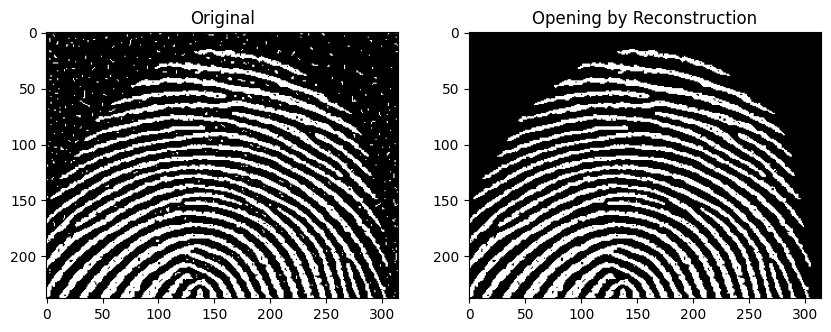

In [26]:
def reconstruction_by_dilation(marker, mask, structuring_element, max_iter=1000):
    reconstruction = marker.copy()
    previous = np.zeros_like(reconstruction)
    iteration = 0
    
    while not np.array_equal(reconstruction, previous) and iteration < max_iter:
        previous = reconstruction.copy()
        # Use your dilation function
        dilated = dilation(reconstruction, structuring_element)
        # Conditioning to mask
        reconstruction = np.minimum(dilated, mask)
        iteration += 1
    return reconstruction

def opening_by_reconstruction(image, kernel_size, erosion_iterations=1):
    structuring_element = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    marker = image.copy()
    for _ in range(erosion_iterations):
        marker = erosion(marker, kernel_size)  
    result = reconstruction_by_dilation(marker, image, structuring_element)
    return result


img = cv2.imread('digital.jpg', 0)
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

result = opening_by_reconstruction(binary_img, kernel_size=3, erosion_iterations=1)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(binary_img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Opening by Reconstruction')
plt.show()

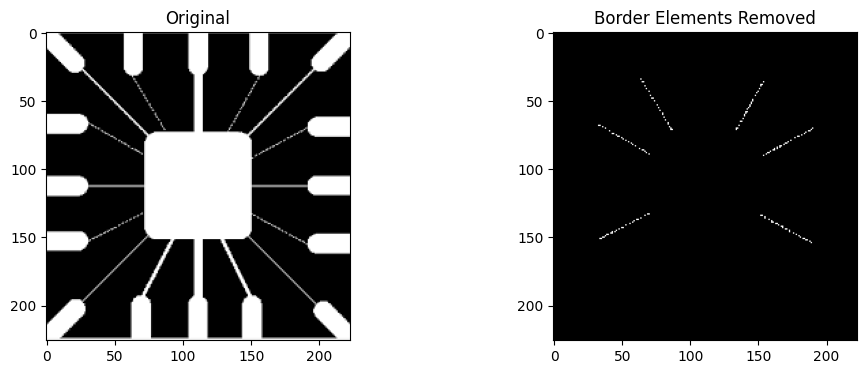

In [27]:
# 2.4 Border elements removal
def remove_border_elements(binary_image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    mask = np.zeros_like(binary_image, dtype=np.uint8)
 
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label] 
        touches_border = (x == 0) or (y == 0) or (x + w == binary_image.shape[1]) or (y + h == binary_image.shape[0])
        if not touches_border:
            mask[labels == label] = 255
    return mask

img = cv2.imread('erosao.png', 0)
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img_no_borders = remove_border_elements(binary_img)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_no_borders, cmap='gray'), plt.title('Border Elements Removed')
plt.show()